https://www.kaggle.com/datasets/shubhammeshram579/bank-customer-churn-prediction - джерело даних

The bank customer churn dataset –  поширений набір даних для прогнозування відтоку клієнтів у банківській галузі. Він містить інформацію про клієнтів банку, які або залишили банк, або продовжують бути його клієнтами. Набір даних включає такі атрибути:

- Customer ID: Унікальний ідентифікатор кожного клієнта
- Surname: Прізвище клієнта
- Credit Score: Числове значення, що відображає кредитний рейтинг клієнта
- Geography: Країна проживання клієнта (Франція, Іспанія або Німеччина)
- Gender: Стать клієнта (Чоловік або Жінка)
- Age: Вік клієнта
- Tenure: Кількість років, протягом яких клієнт обслуговується в банку
- Balance: Баланс на рахунку клієнта
- NumOfProducts: Кількість банківських продуктів, якими користується клієнт (наприклад, ощадний рахунок, кредитна картка)
- HasCrCard: Наявність кредитної картки у клієнта (1 = так, 0 = ні)
- IsActiveMember: Чи є клієнт активним учасником (1 = так, 0 = ні)
- EstimatedSalary: Оцінка заробітної плати клієнта
- Exited: Чи залишив клієнт банк (1 = так, 0 = ні)


## Завантаження бібліотек та даних

In [1]:
import numpy as np
import pandas as pd
import random
random.seed(42)
np.random.seed(42)

from process_bank_churn import preprocess_data
from ml_utils import auroc_train_and_val, predict_and_plot
from genetic_search import (initialize_population, crossover,
                            mutate,calculate_fitness,
                            genetic_algorithm_improved)

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_auc_score

In [2]:
raw_df = pd.read_csv('https://raw.githubusercontent.com/OlenaKirieva/Genetic_tree_optimizer/refs/heads/main/bank-customer-churn-prediction.csv')
raw_df.head()


,id,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,0,15779985.0,Nwankwo,678.0,France,Male,29.0,4.0,0.00,3.0,1.0,0.0,180626.36,0.0
1,1,15650086.0,Ch'in,687.0,France,Female,34.0,1.0,0.00,2.0,0.0,1.0,63736.17,0.0
2,2,15733602.0,Thompson,682.0,France,Female,52.0,6.0,0.00,3.0,0.0,0.0,179655.87,1.0
3,3,15645794.0,Macleod,753.0,Germany,Male,44.0,6.0,83347.25,2.0,1.0,0.0,161407.48,0.0
4,4,15633840.0,Hsia,544.0,Germany,Female,55.0,0.0,107747.57,1.0,1.0,0.0,176580.86,1.0


## Розподіл цільової змінної

In [3]:
raw_df.Exited.value_counts()

,count
Exited,
0.0,11948
1.0,3052


In [4]:
raw_df.Exited.value_counts(normalize = True).round(4)*100

,proportion
Exited,
0.0,79.65
1.0,20.35


## Розбиття даних на навчальну, валідаційну та тестову вибірки

In [5]:
data = preprocess_data(raw_df, scale_numeric=True)

X_train = data['X_train']
train_targets = data['y_train']
X_val = data['X_val']
val_targets = data['y_val']

X_train, X_test, train_targets, test_targets = train_test_split(
    X_train, train_targets, test_size=0.2, stratify=train_targets, random_state=42
)

## Параметри для алгоритму DecisionTreeClassifier

In [6]:
params_dt = {
    'criterion': ['gini', 'entropy'],
    'splitter': ['best', 'random'],
    'max_depth': np.arange(1, 20),
    'max_leaf_nodes': np.arange(2, 20),
    'min_samples_split': [2, 5, 10, 20],
    'min_samples_leaf': [1, 2, 4, 8],
    'max_features': [None, 'sqrt', 'log2']
}

## Отримання найкращих гіперпараметрів за GA та фінальна оцінка

In [7]:
%%time
best_parameters, best_score = genetic_algorithm_improved(X_train, X_val, train_targets, val_targets, params_dt)

CPU times: user 2.32 s, sys: 4.66 ms, total: 2.33 s
Wall time: 3.03 s


In [8]:
clean_params = {k: (int(v) if isinstance(v, np.integer) else v)
                for k, v in best_parameters.items()}

for k, v in clean_params.items():
    print(f"{k:20s}: {v}")

print(f"Best Score: { best_score:.4f}")

criterion           : entropy
splitter            : best
max_depth           : 6
max_leaf_nodes      : 19
min_samples_split   : 5
min_samples_leaf    : 1
max_features        : None
Best Score: 0.9202


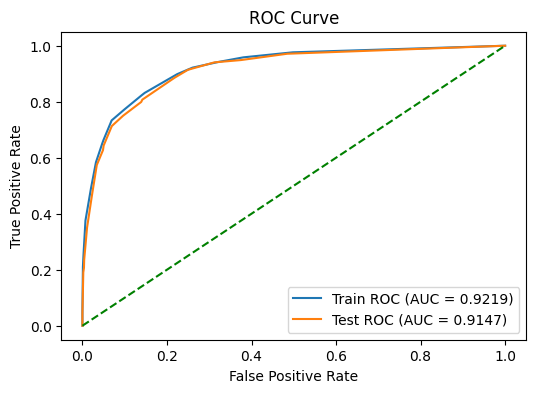

In [9]:
# Остаточна оцінка на тестовому наборі
final_model_ga = DecisionTreeClassifier(random_state=42, **best_parameters)
final_model_ga.fit(X_train, train_targets)
auroc_train_and_val(final_model_ga, X_train, X_test, train_targets, test_targets)

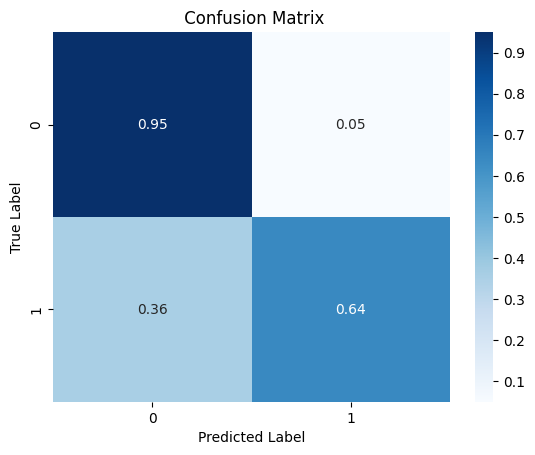

              precision  recall  f1-score   support
0.0               0.913   0.950     0.931  1912.000
1.0               0.766   0.643     0.699   488.000
accuracy          0.888   0.888     0.888     0.888
macro avg         0.839   0.797     0.815  2400.000
weighted avg      0.883   0.888     0.884  2400.000


In [10]:
predict_and_plot(final_model_ga, X_test, test_targets)

## Отримання найкращих гіперпараметрів з Random Search та фінальна оцінка

In [11]:
from itertools import product

# Generate all possible hyperparameter combinations
all_combinations = list(product(*params_dt.values()))

# Convert the combinations into dictionaries
hyperparameter_combinations = [dict(zip(params_dt.keys(), values)) for values in all_combinations]

# Print the number of combinations and a sample combination
print("Number of combinations:", len(hyperparameter_combinations))
print("Sample combination:", hyperparameter_combinations[0])

Number of combinations: 65664
Sample combination: {'criterion': 'gini', 'splitter': 'best', 'max_depth': np.int64(1), 'max_leaf_nodes': np.int64(2), 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': None}


In [12]:
%%time
random.seed(42)
random.shuffle(hyperparameter_combinations)
auroc_metrics = []
for parameters in hyperparameter_combinations[:100]:
    auroc_metrics.append(calculate_fitness( X_train, X_val, train_targets, val_targets, parameters))

best_score = np.argmax(auroc_metrics)

CPU times: user 1.95 s, sys: 471 µs, total: 1.95 s
Wall time: 4.06 s


In [13]:
clean_params = {k: (int(v) if isinstance(v, np.integer) else v)
                for k, v in hyperparameter_combinations[best_score].items()}

for k, v in clean_params.items():
    print(f"{k:20s}: {v}")

print(f"Best Score: {auroc_metrics[best_score]:.4f}")

criterion           : entropy
splitter            : best
max_depth           : 16
max_leaf_nodes      : 19
min_samples_split   : 20
min_samples_leaf    : 4
max_features        : None
Best Score: 0.9193


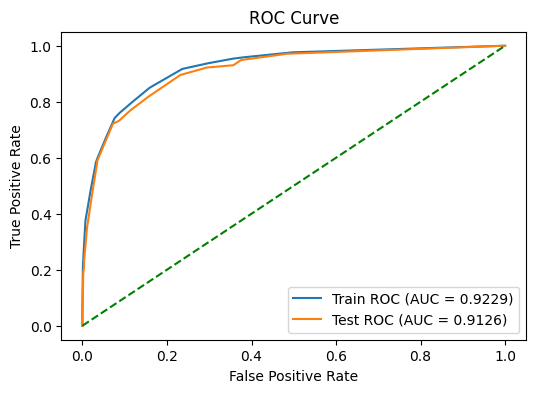

In [14]:
# Остаточна оцінка на тестовому наборі для RandomSearch
final_model_gs = DecisionTreeClassifier(random_state=42, **hyperparameter_combinations[best_score])
final_model_gs.fit(X_train, train_targets)
auroc_train_and_val(final_model_gs, X_train, X_test, train_targets, test_targets)

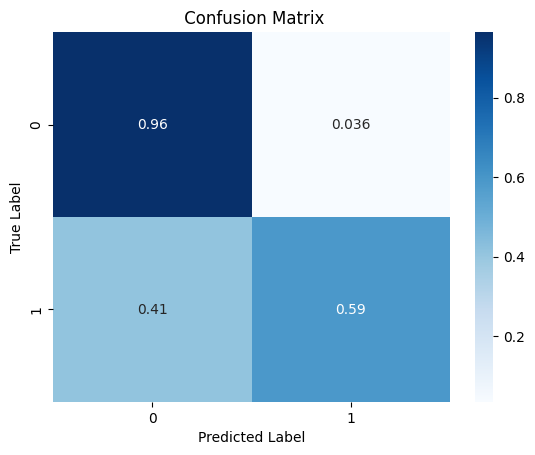

              precision  recall  f1-score   support
0.0               0.902   0.964     0.932  1912.000
1.0               0.809   0.590     0.682   488.000
accuracy          0.888   0.888     0.888     0.888
macro avg         0.856   0.777     0.807  2400.000
weighted avg      0.883   0.888     0.881  2400.000


In [15]:
predict_and_plot(final_model_gs, X_test, test_targets)